# TINT Demonstration


This notebook will take you through the following process:

1. DATA - Obtain nexrad data from Amazon S3
2. GRID - Map data to cartesian grids using Py-ART
3. TRACK - Perform cell tracking using TINT
4. VISUALIZE - Visualize the tracks
5. ANALYZE - Perfrom some basic analysis on the tracking output

In [1]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image, display
import tempfile
import os
import shutil

import pyart
from tint.data_utils import get_nexrad_keys, read_nexrad_key
from tint import Cell_tracks, animate
from tint.visualization import embed_mp4_as_gif


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## 1. DATA


In [2]:
# Let's get some nexrad data from Amazon S3 to use for tracking
keys = get_nexrad_keys('khgx', start='20150710_183000', end='20150710_193000')

Found 13 keys.


In [3]:
# We can visualize this data using pyart and matplotlib
fig = plt.figure(figsize=(10, 7))


def plot_ppi(key):
    """ Plots ppi map of nexrad data given S3 key. """
    plt.clf()
    radar = read_nexrad_key(key)
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi_map('reflectivity', resolution='l',
                         sweep=3, fig=fig, width=200000, height=200000)
    del display, radar


ppi_anim = FuncAnimation(fig, plot_ppi, frames=keys, interval=1000)
HTML(ppi_anim.to_jshtml())

## 2. GRID

### Disclaimer
If you don't want this data to remain on your filesystem, make sure you run the last cell in this notebook. If your kernel crashes for some reason, you can manually remove the the path printed after the following cell.

In [4]:
# These radar volumes look interesting.
# Let's make a function that maps them to a cartesian grid using pyart.
# Most of the cells seem to be in the bottom right quadrant, so we'll only grid
# that part of the domain to save time.

def get_grid(radar):
    """ Returns grid object from radar object. """
    grid = pyart.map.grid_from_radars(
        radar, grid_shape=(20, 200, 200),
        grid_limits=((0, 10000), (100000, 0), (0, 100000)),
        fields=['reflectivity'], gridding_algo='map_gates_to_grid')
    return grid


# Let's write these grids to a temporary location so that we can reuse them.
tmp_dir = tempfile.mkdtemp()
print('temporary directory:', tmp_dir)
filenames = []
for num, key in enumerate(keys):
    print('saving grid', num)
    radar = read_nexrad_key(key)
    grid = get_grid(radar)
    name = os.path.join(tmp_dir, 'grid_' + str(num).zfill(3) + '.nc')
    filenames.append(name)
    pyart.io.write_grid(name, grid)
    del radar, grid

temporary directory: /tmp/tmpthagh98s
saving grid 0
saving grid 1
saving grid 2
saving grid 3
saving grid 4
saving grid 5
saving grid 6
saving grid 7
saving grid 8
saving grid 9
saving grid 10
saving grid 11
saving grid 12


In [5]:
# Now we can easily instantiate generators of these grids like so
grids = (pyart.io.read_grid(fn) for fn in filenames)

## 3. TRACK

In [6]:
# First, let's instantiate a tracks object and view the default parameters
tracks_obj = Cell_tracks()
tracks_obj.params

{'FIELD_THRESH': 32,
 'FLOW_MARGIN': 10000,
 'GS_ALT': 1500,
 'ISO_SMOOTH': 3,
 'ISO_THRESH': 8,
 'MAX_DISPARITY': 999,
 'MAX_FLOW_MAG': 50,
 'MAX_SHIFT_DISP': 15,
 'MIN_SIZE': 8,
 'SEARCH_MARGIN': 4000}

In [7]:
# Those parameter values look fine for now. Let's try some tracking. 
# We'll give the generator of grids we made earlier to the get_tracks method of our tracks object.
tracks_obj.get_tracks(grids)

Writing tracks for scan 0
No cells found in scan 1
No cells found in scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
Writing tracks for scan 7
Writing tracks for scan 8


/home/mhpicel/anaconda3/lib/python3.5/site-packages/tint/matching.py:64: RuntimeWarning: invalid value encountered in true_divide
  unit = shift_meters/shift_mag


Writing tracks for scan 9
Writing tracks for scan 10
Writing tracks for scan 11
No cells found in scan 12


time elapsed 0.0 minutes


In [8]:
# Now we can view the 'tracks' attribute of our tracks object to see the results.
tracks_obj.tracks

area   grid_x  grid_y isolated      lat      lon        max  \
scan uid                                                                     
0    0    11.110831  121.636  77.841     True  28.9236 -94.4488  43.620998   
3    1     8.585642  128.147   1.647     True  28.5800 -94.4200  38.297997   
4    1    14.646095  126.466   2.793     True  28.5846 -94.4303  38.663410   
5    2     8.838161   67.000   2.371     True  28.5812 -94.7339  36.217911   
     1    16.161208  124.922   3.344     True  28.5846 -94.4354  38.151047   
6    2    13.636019   65.389   3.389     True  28.5857 -94.7442  39.693333   
     1    17.928840  122.972   5.324     True  28.5937 -94.4457  36.859787   
7    2    15.403651   64.426   5.082    False  28.5948 -94.7493  40.320805   
8    2    14.393576   63.737   6.895    False  28.6038 -94.7493  39.939823   
9    2    12.625944   62.680   8.480    False  28.6083 -94.7544  37.936493   
10   2    13.130982   61.212  10.423    False  28.6174 -94.7647  39.649536   
     3    12.373425   24.980  11.490    False  28.6222 -94.9500  39.503281   
11   2    10.605793   59.833  11.952    False  28.6265 -94.7698  38.199684   

           max_alt                time        vol  
scan uid                                           
0    0    4.210526 2015-07-10 18:34:06  40.535925  
3    1    4.736842 2015-07-10 18:47:00  27.777076  
4    1    6.315789 2015-07-10 18:51:19  64.458766  
5    2    4.736842 2015-07-10 18:55:37  29.106123  
     1    4.736842 2015-07-10 18:55:37  50.902489  
6    2    5.263158 2015-07-10 19:00:09  52.630250  
     1    4.210526 2015-07-10 19:00:09  41.864972  
7    2    5.263158 2015-07-10 19:04:27  54.756725  
8    2    5.263158 2015-07-10 19:08:45  55.554153  
9    2    4.736842 2015-07-10 19:13:04  45.985016  
10   2    5.263158 2015-07-10 19:17:36  54.889629  
     3    4.736842 2015-07-10 19:17:36  43.725637  
11   2    4.736842 2015-07-10 19:21:54  35.884261

## 4. VISUALIZE

In [9]:
# We can visualize these tracks to assess the performance of the algorithm.
# First we need to make another generator of the same grids for the animator
grids = (pyart.io.read_grid(fn) for fn in filenames)

In [10]:
# Let's save the animation in our temp directory so that it will be cleaned up later.
animate(tracks_obj, grids, os.path.join(tmp_dir, 'tint_demo_anim'))

Animating 12 frames
Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12


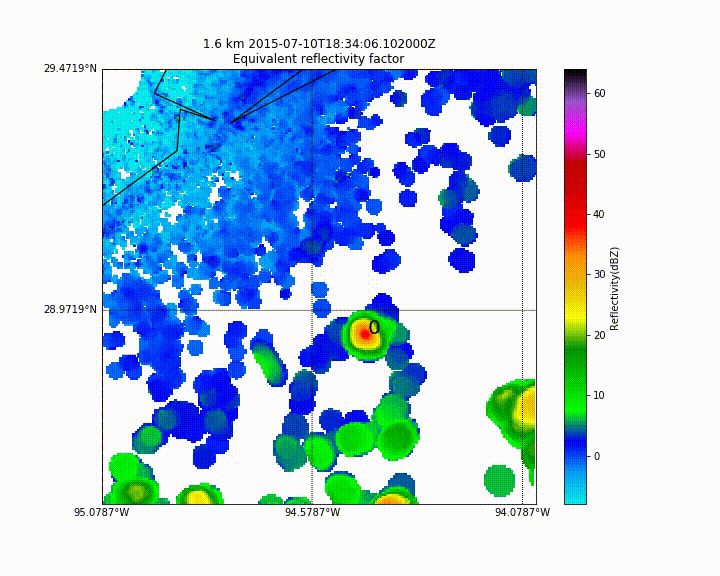

In [11]:
# The animator saved an mp4 to our local directory. Now we can embed it as a gif in this notebook.
embed_mp4_as_gif(os.path.join(tmp_dir, 'tint_demo_anim.mp4'))

In [12]:
grids = (pyart.io.read_grid(fn) for fn in filenames)
animate(tracks_obj, grids, os.path.join(tmp_dir, 'tint_demo_lagrangian'), style='lagrangian', uid='2')

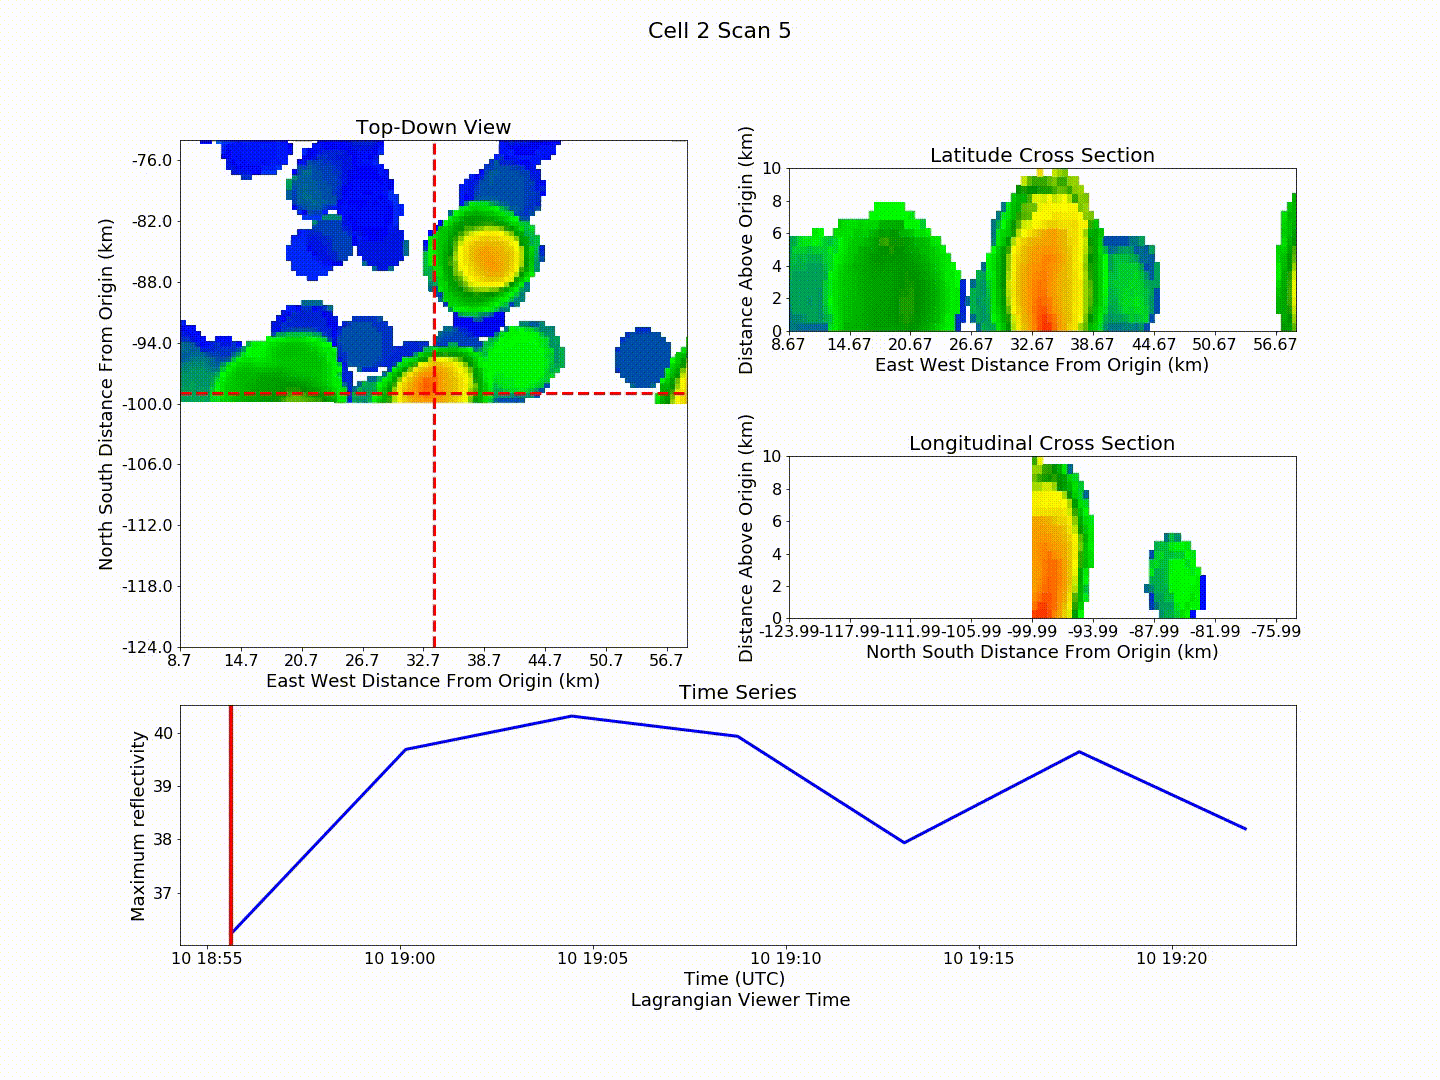

In [13]:
embed_mp4_as_gif(os.path.join(tmp_dir, 'tint_demo_lagrangian.mp4'))

## Clean Up

In [ ]:
# Now we can delete the directory containing all the data and output from this demo.
shutil.rmtree(tmp_dir)
print('temporary directory removed')